In [1]:
import pandas as pd

In [2]:
!pip install opendatasets --quiet
import opendatasets as od

od.download("https://www.kaggle.com/datasets/adilshamim8/tesla-stock-price-history")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mohamedismail11
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adilshamim8/tesla-stock-price-history


100%|██████████| 91.2k/91.2k [00:00<00:00, 283MB/s]

In [3]:
import os

os.listdir('./tesla-stock-price-history')

['Tesla_stock_data.csv']

In [4]:
df = pd.read_csv('./tesla-stock-price-history/Tesla_stock_data.csv')
df.head()

,Date,Close,High,Low,Open,Volume
0,2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
1,2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2,2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
3,2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
4,2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861 entries, 0 to 3860
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3861 non-null   object 
 1   Close   3861 non-null   float64
 2   High    3861 non-null   float64
 3   Low     3861 non-null   float64
 4   Open    3861 non-null   float64
 5   Volume  3861 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 181.1+ KB


In [7]:
data = df['Close']
data.head()

,Close
0,1.592667
1,1.588667
2,1.464000
3,1.280000
4,1.074000


In [8]:
data.shape

(3861,)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(np.array(data).reshape(-1,1)) # df[['close]]

In [10]:
data_scaled

array([[1.12641280e-03],
       [1.11805880e-03],
       [8.57688465e-04],
       ...,
       [9.61675604e-01],
       [9.16960261e-01],
       [9.51337377e-01]])

In [11]:
train_size = int(len(data_scaled)*0.8)
test_size = len(data_scaled) - train_size

print("Train size:", train_size)
print("Test size:", test_size)

Train size: 3088
Test size: 773


In [12]:
train_data = data_scaled[:train_size, :]
test_data = data_scaled[train_size - 60:, :]

In [13]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [14]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [15]:
x_train.shape

(3028, 60)

In [16]:
y_train.shape

(3028,)

In [17]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [18]:
x_train.shape

(3028, 60, 1)

In [19]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import  EarlyStopping

In [20]:
model = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    GRU(units=50, return_sequences=False),
    Dense(units=25, activation='relu'),
    Dense(units=1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

call_back = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[call_back])

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0129 - mean_absolute_error: 0.0535
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5743e-04 - mean_absolute_error: 0.0088
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9284e-04 - mean_absolute_error: 0.0073
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8729e-04 - mean_absolute_error: 0.0078
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7734e-04 - mean_absolute_error: 0.0072
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5079e-04 - mean_absolute_error: 0.0066
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6705e-04 - mean_absolute_error: 0.0073
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4470e-04 - mean_absolute_error: 0.0073
Epoch 9/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3091e-04 - mean_absolute_error: 0.0065
Epoch 10/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6757e-04 - mean_absolute_error: 0.0078
E

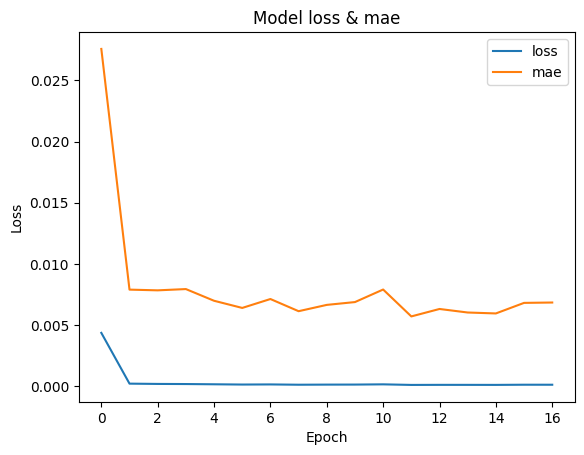

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.title('Model loss & mae')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'mae'])
plt.show()

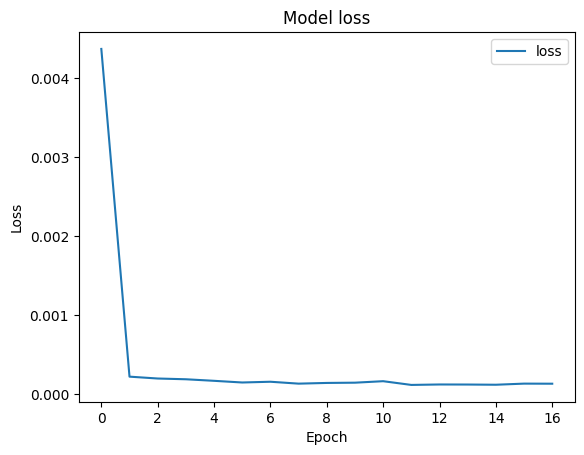

In [24]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'])
plt.show()

In [25]:
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [26]:
import time
start = time.time()
preds = model.predict(x_test)
end = time.time()
print("Time taken:", end-start)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Time taken: 0.4432961940765381


In [27]:
preds = model.predict(x_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [28]:
preds

array([[0.53759116],
       [0.5283467 ],
       [0.518148  ],
       [0.51037896],
       [0.489993  ],
       [0.4786428 ],
       [0.46766868],
       [0.46357724],
       [0.4680746 ],
       [0.45274603],
       [0.45852828],
       [0.46598792],
       [0.47191018],
       [0.45768848],
       [0.45573476],
       [0.4533468 ],
       [0.46477544],
       [0.47514716],
       [0.4803436 ],
       [0.48583028],
       [0.48729423],
       [0.48756334],
       [0.4727321 ],
       [0.46364385],
       [0.45146945],
       [0.43349925],
       [0.4175714 ],
       [0.39518887],
       [0.3976504 ],
       [0.4091778 ],
       [0.41095647],
       [0.41402012],
       [0.40754202],
       [0.39859167],
       [0.39053747],
       [0.37333712],
       [0.3654126 ],
       [0.37752423],
       [0.38694125],
       [0.39121827],
       [0.39019015],
       [0.40393692],
       [0.4134124 ],
       [0.41739509],
       [0.4046333 ],
       [0.39256167],
       [0.38044176],
       [0.373

In [29]:
preds_origin = scaler.inverse_transform(preds)
preds_origin

array([[258.45554 ],
       [254.02925 ],
       [249.14603 ],
       [245.42616 ],
       [235.66525 ],
       [230.23068 ],
       [224.97621 ],
       [223.0172  ],
       [225.17056 ],
       [217.83115 ],
       [220.59973 ],
       [224.17145 ],
       [227.00706 ],
       [220.19763 ],
       [219.26218 ],
       [218.11879 ],
       [223.59091 ],
       [228.55696 ],
       [231.04504 ],
       [233.6721  ],
       [234.37305 ],
       [234.5019  ],
       [227.4006  ],
       [223.04909 ],
       [217.21991 ],
       [208.61566 ],
       [200.9893  ],
       [190.2724  ],
       [191.45099 ],
       [196.9704  ],
       [197.82202 ],
       [199.28893 ],
       [196.18716 ],
       [191.90167 ],
       [188.04527 ],
       [179.80963 ],
       [176.01532 ],
       [181.81445 ],
       [186.32338 ],
       [188.37125 ],
       [187.87898 ],
       [194.46101 ],
       [198.99794 ],
       [200.90488 ],
       [194.79446 ],
       [189.01448 ],
       [183.21138 ],
       [180.0

In [30]:
x_test

array([[[0.48723217],
        [0.48457279],
        [0.49286421],
        ...,
        [0.55796355],
        [0.55178153],
        [0.5040587 ]],

       [[0.48457279],
        [0.49286421],
        [0.49552362],
        ...,
        [0.55178153],
        [0.5040587 ],
        [0.51876194]],

       [[0.49286421],
        [0.49552362],
        [0.49918549],
        ...,
        [0.5040587 ],
        [0.51876194],
        [0.50073796]],

       ...,

       [[0.64256974],
        [0.66594035],
        [0.67086924],
        ...,
        [0.90363546],
        [0.94269091],
        [0.95967057]],

       [[0.66594035],
        [0.67086924],
        [0.68628257],
        ...,
        [0.94269091],
        [0.95967057],
        [0.9616756 ]],

       [[0.67086924],
        [0.68628257],
        [0.70587295],
        ...,
        [0.95967057],
        [0.9616756 ],
        [0.91696026]]])

In [31]:
preds

array([[0.53759116],
       [0.5283467 ],
       [0.518148  ],
       [0.51037896],
       [0.489993  ],
       [0.4786428 ],
       [0.46766868],
       [0.46357724],
       [0.4680746 ],
       [0.45274603],
       [0.45852828],
       [0.46598792],
       [0.47191018],
       [0.45768848],
       [0.45573476],
       [0.4533468 ],
       [0.46477544],
       [0.47514716],
       [0.4803436 ],
       [0.48583028],
       [0.48729423],
       [0.48756334],
       [0.4727321 ],
       [0.46364385],
       [0.45146945],
       [0.43349925],
       [0.4175714 ],
       [0.39518887],
       [0.3976504 ],
       [0.4091778 ],
       [0.41095647],
       [0.41402012],
       [0.40754202],
       [0.39859167],
       [0.39053747],
       [0.37333712],
       [0.3654126 ],
       [0.37752423],
       [0.38694125],
       [0.39121827],
       [0.39019015],
       [0.40393692],
       [0.4134124 ],
       [0.41739509],
       [0.4046333 ],
       [0.39256167],
       [0.38044176],
       [0.373

In [32]:
rmse = np.sqrt(np.mean(preds - y_test)**2)
print("RMSE:", rmse.round(4))

RMSE: 0.0103


In [33]:
train_data

array([[0.00112641],
       [0.00111806],
       [0.00085769],
       ...,
       [0.55796355],
       [0.55178153],
       [0.5040587 ]])

In [34]:
test_data

array([[0.48723217],
       [0.48457279],
       [0.49286421],
       [0.49552362],
       [0.49918549],
       [0.50018797],
       [0.5105958 ],
       [0.5147102 ],
       [0.56526644],
       [0.56638731],
       [0.55842997],
       [0.53843582],
       [0.57176874],
       [0.58446694],
       [0.61840549],
       [0.61867006],
       [0.62558307],
       [0.63980593],
       [0.64238873],
       [0.59965057],
       [0.6043567 ],
       [0.58954906],
       [0.61257153],
       [0.59643422],
       [0.62442045],
       [0.64382287],
       [0.63806547],
       [0.63270495],
       [0.63035186],
       [0.61739602],
       [0.60329153],
       [0.6169505 ],
       [0.61829414],
       [0.61614991],
       [0.59948345],
       [0.59265399],
       [0.5777837 ],
       [0.57341863],
       [0.57665588],
       [0.5621406 ],
       [0.57093334],
       [0.59031485],
       [0.60192705],
       [0.62368945],
       [0.63358911],
       [0.60792111],
       [0.62980882],
       [0.632

In [35]:
preds

array([[0.53759116],
       [0.5283467 ],
       [0.518148  ],
       [0.51037896],
       [0.489993  ],
       [0.4786428 ],
       [0.46766868],
       [0.46357724],
       [0.4680746 ],
       [0.45274603],
       [0.45852828],
       [0.46598792],
       [0.47191018],
       [0.45768848],
       [0.45573476],
       [0.4533468 ],
       [0.46477544],
       [0.47514716],
       [0.4803436 ],
       [0.48583028],
       [0.48729423],
       [0.48756334],
       [0.4727321 ],
       [0.46364385],
       [0.45146945],
       [0.43349925],
       [0.4175714 ],
       [0.39518887],
       [0.3976504 ],
       [0.4091778 ],
       [0.41095647],
       [0.41402012],
       [0.40754202],
       [0.39859167],
       [0.39053747],
       [0.37333712],
       [0.3654126 ],
       [0.37752423],
       [0.38694125],
       [0.39121827],
       [0.39019015],
       [0.40393692],
       [0.4134124 ],
       [0.41739509],
       [0.4046333 ],
       [0.39256167],
       [0.38044176],
       [0.373

In [36]:
train = train_data
test = test_data[60::]
predictions_ = preds

train.shape, test.shape, preds.shape

((3088, 1), (773, 1), (773, 1))

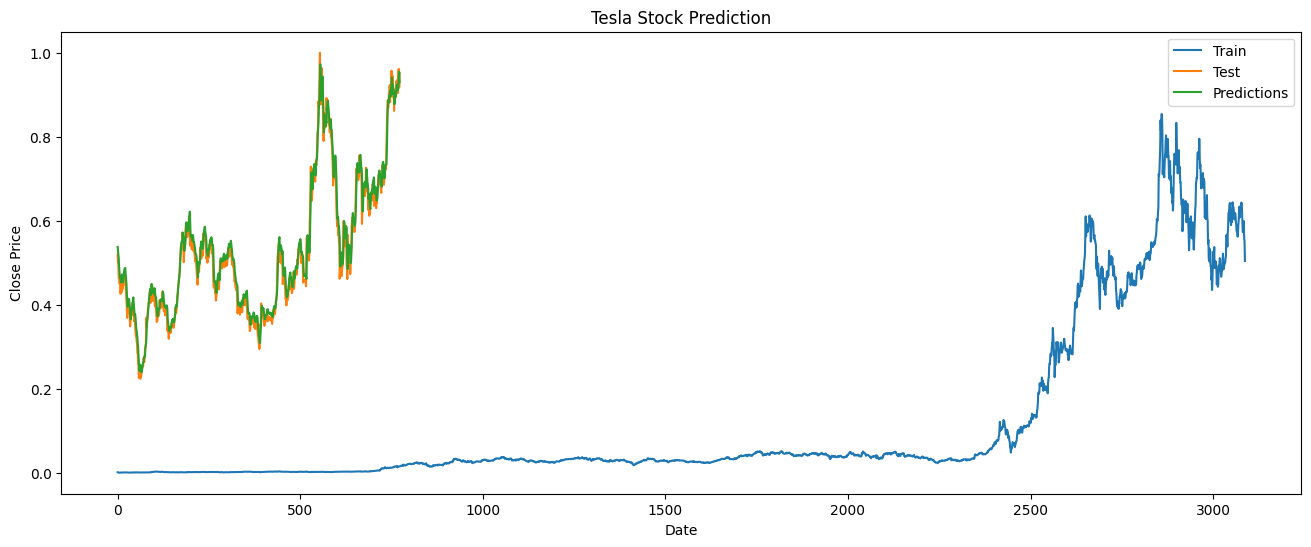

In [37]:
plt.figure(figsize=(16, 6))
plt.title("Tesla Stock Prediction")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions_, label='Predictions')
plt.legend()
plt.show()

In [38]:
preds

array([[0.53759116],
       [0.5283467 ],
       [0.518148  ],
       [0.51037896],
       [0.489993  ],
       [0.4786428 ],
       [0.46766868],
       [0.46357724],
       [0.4680746 ],
       [0.45274603],
       [0.45852828],
       [0.46598792],
       [0.47191018],
       [0.45768848],
       [0.45573476],
       [0.4533468 ],
       [0.46477544],
       [0.47514716],
       [0.4803436 ],
       [0.48583028],
       [0.48729423],
       [0.48756334],
       [0.4727321 ],
       [0.46364385],
       [0.45146945],
       [0.43349925],
       [0.4175714 ],
       [0.39518887],
       [0.3976504 ],
       [0.4091778 ],
       [0.41095647],
       [0.41402012],
       [0.40754202],
       [0.39859167],
       [0.39053747],
       [0.37333712],
       [0.3654126 ],
       [0.37752423],
       [0.38694125],
       [0.39121827],
       [0.39019015],
       [0.40393692],
       [0.4134124 ],
       [0.41739509],
       [0.4046333 ],
       [0.39256167],
       [0.38044176],
       [0.373

In [39]:
test

array([[0.51876194],
       [0.50073796],
       [0.49514072],
       [0.46368753],
       [0.46345779],
       [0.4499659 ],
       [0.45151142],
       [0.46086801],
       [0.42592698],
       [0.45591821],
       [0.45767257],
       [0.46153632],
       [0.43070969],
       [0.44566354],
       [0.43900114],
       [0.46232997],
       [0.4669665 ],
       [0.46790633],
       [0.47506999],
       [0.47302321],
       [0.47360803],
       [0.44679133],
       [0.44748055],
       [0.43110652],
       [0.40940674],
       [0.39733506],
       [0.36870136],
       [0.39612371],
       [0.40708847],
       [0.39660406],
       [0.40385125],
       [0.38818731],
       [0.38035534],
       [0.37413154],
       [0.34840089],
       [0.3526615 ],
       [0.38041799],
       [0.3797079 ],
       [0.3798332 ],
       [0.37546819],
       [0.40443603],
       [0.40443603],
       [0.40477021],
       [0.37885159],
       [0.37335879],
       [0.36128709],
       [0.36003399],
       [0.371

In [40]:
train

array([[0.00112641],
       [0.00111806],
       [0.00085769],
       ...,
       [0.55796355],
       [0.55178153],
       [0.5040587 ]])

In [41]:
train[-1]

array([0.5040587])

In [42]:
x = scaler.inverse_transform([[0.59265399]])

In [43]:
x

array([[284.82000597]])